<a href="https://colab.research.google.com/github/clemencia/ML4PPGF_UERJ/blob/master/Ensemble_Learning_and_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--BOOK_INFORMATION-->
<img align="left" width= 120 style="padding-right:10px;" src="https://covers.oreillystatic.com/images/0636920052289/lrg.jpg">

*Essa aula é inteiramente baseada no **capítulo 7** do livro [Hands-On Machine Learning with Scikit-Learn & TensorFlow](http://shop.oreilly.com/product/0636920052289.do) por Aurélien Geron; os notebooks do livro estão disponíveis [no GitHub](https://github.com/ageron/handson-ml).*

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*Alguns exemplos foram tirados do livro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) por Jake VanderPlas; disponível [no GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*


# Random Forests


*   Resumo de `Decision Trees`
   * Resolução dos exercícios


1.   Voting Classifiers
2.   Bagging and Pasting
3.   Random Patches and Random Subspaces
4.   Random Forests
5.   Boosting
6.   Stacking
7.   Exercícios

## Resumo de Decision Trees
Na aula passada vimos que as `Decision Trees` são um algoritmo de ML **Supervisionado** e são usadas para **classificar** e **estimar**. 

São bastante sensíveis aos hyperparâmetros. Ao usarmos uma `Decision Tree`, devemos escolher com cuidado os parâmetros de input do nosso Estimador/Classificador.


### Exercícios (livro, capítulo 6):

7. Treine e ajuste a `Decision Tree` do conjunto de dados de "luas" (*moon's dataset*).

   1. Gere o conjunto de dados de "luas" usando `make_moons(n_samples=10000, noise=0.4)`;

In [0]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [0]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

2. Divida-o em um conjunto de treino e um de teste, usando a função `train_test_split()`;
   
   

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 3. Use o método de busca com validação cruzada (*grid search with cross-validation*), com a ajuda da classe `GridSearchCV` para encontrar bons valores de hyperparâmetros para um `DecisionTreeClassifier`. Dica: tente diferentes valores para `max_leaf_nodes`;
 
 **Cross-validation:**
 
 
 Quando precisamos testar vários conjuntos de hyperparâmetros para determinar o melhor modelo, se testarmos todos os conjuntos no mesmo conjunto de teste, podemos estar introduzindo um ***bias***. Para evitar isso, podemos sub-dividir nossa amostra de teste em duas amostras: 
 * validação (escolha do modelo apropriado)
 * teste (aplicação do melhor modelo)
 


Para não "gastarmos" dados de treinamento em conjuntos de validação, uma técnica comum é:
* **dividir** a amostra de treinamento em diferentes subconjuntos;
* **treinar** cada modelo (combinações de hyperparâmetros) em uma **combinação** diferente dessas sub-amostras;
* **validar** cada modelo nas sub-amostras restantes;
* Uma vez que o modelo foi determinado, **testar** na amostra de teste.



In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    7.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 

In [0]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

1. Treine o estimador no conjunto de dados completo usando esses hyperparâmetros e meça o desempenho do seu modelo no conjunto de dados de teste. Você deve obter uma acurácia de aproximadamente 85% a 87%.

==> **Por default**, o `GridSearchCV` já treina o melhor modelo encontrado no conjunto completo de treinamento (`refit=True`).

Podemos calcular a acurácia diretamente:   
   


In [0]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

8. **Faça crescer uma floresta.**

   1. Continuando do exercício anterior, gere 1000 sub-conjuntos do conjunto de treinamento, cada sub-conjunto contendo 100 instâncias selecionadas aleatoriamente. Dica: você pode usar a classe do scikit-learn, `ShuffleSplit`;
   
   

In [0]:
print(len(X_train))

8000


In [0]:
from sklearn.model_selection import ShuffleSplit
"""
Geração de n_trees (1000) trees a serem treinadas em conjuntos de 
n_instances dados.
Para cada tree, a função rs.split() faz uma rearrumação dos índices de uma sub-amostra de teste
e com isso produz uma mini-amostra de treinamento, com "n_instances" cada.
Nesse exemplo abaixo, geramos "n_trees" amostras com "n_instances" dados cada.

"""
n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    #print("TRAIN size:", len(mini_train_index), "TEST size:", len(mini_test_index) )
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))
    
# As "n_trees" amostras de treinamento estão em "mini_sets".
print(len(mini_sets))

1000


1. Treine uma `Decision Tree` em cada sub-conjunto, usando os melhores valores de hyperparâmetro encontrados no exercício anterior. Estime o desempenho desses 1000 conjuntos de treinamento no conjunto de teste (como eles foram treinados em um número menor de amostras, a performance será um pouco pior do que a encontrada no exercício anterior, com uma acurácia em torno de 80%);
   
   

In [0]:
from sklearn.base import clone

# copiando a melhor configuração da tree para todas as "n_trees" trees. 
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    # para cada conjunto de treinamento (mini_train), treinamos as nossas trees
    tree.fit(X_mini_train, y_mini_train)
    # fazemos a predição no conjunto de teste
    y_pred = tree.predict(X_test)
    # e calculamos a acurácia de cada predição
    accuracy_scores.append(accuracy_score(y_test, y_pred))
# média das acurácias
np.mean(accuracy_scores)

0.8054499999999999

1. Para cada instância do conjunto de teste, gere as predições das 1000 `Decision Trees` e só guarde as predições mais frequentes (você pode usar a função `mode()` do  SciPy). Isso fornece o que é conhecido como *majority vote predictions* do conjunto de teste;
   
   

In [0]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)
    

In [0]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)
print(accuracy_score(y_test, y_pred_majority_votes.reshape([-1])))

0.872


1. Estime as predições no conjunto de teste: você deve obteve no conjunto de teste: a acurácia deve ser um pouco maior que a do item anterior (da ordem de 0.5 a 1.5%). **Parabéns!** Você treinou um classificador `Random Forest`! :-)

## Ensemble Learning e Random Forests

**Ensemble learning**: método onde se usa a informação **agregada** de um conjunto (*ensemble*) de estimadores (classificadores ou métodos de regressão) para se obter uma estimativa.


\\
**Random Forests**: 
* treinar um grupo de `Decision Trees` em subconjuntos (aleatórios distintos) do conjunto de treinamento;
* para fazer predições, obtém-se a predição de cada `Decision Tree` individualmente;
* a predição final é o valor que ocorre com mais frequência.

### Voting Classifiers 
(Clasificadores de votação)

![hard voting](https://i.stack.imgur.com/W7UmY.png)


Criação e treinamento de um 'voting classifier' usando 'scikit-learn':

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') # estimators : list of (string, estimator) tuples

In [0]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [0]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


No exemplo acima, o 'Voting Classifier' obteve uma acurácia maior que as dos outros classificadores considerados individualmente. 

obs.:  Quanto mais independentes os classificadores usados no 'Ensemble Learning', melhor a performance.

Podemos também considerar as probabilidades de classificação, considerando que os classificadores têm o método 'predict_proba()' e decidir pelo classificador com a maior média das probabilidades.

In [0]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42) # temos que forçar o SVC a calcular a probabilidade

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [68]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


### Bagging and Pasting

**Bagging**: **B**ootstrap **aggr**egat**ing** ==> amostragem com substituição (sampling with replacement): seleção de uma sub-amostra escolhida aleatoriamente de uma amostra, podendo haver **reutilização de valores**.

**Pasting**: amostragem **sem reutilização de valores**.

![bagging](http://dfnae.fis.uerj.br/twiki/pub/DFNAE/ML4PPGF/Bagging_pasting.png)

A função de agregação é em geral o `hard voting` para classificadores e a média das probabilidades para a regressão. 

#### Bagging ensembles

Um classificador `bagging` com o `scikit-learn`:

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [70]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


Um classificador de `Decision Tree`

In [71]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Abaixo comparamos os limites de decisão da `Decision Tree` com o `Bagging` usando o conjunto de dados `moon's dataset`.

O método de ensemble generaliza melhor os dados do que uma única `Decision Tree`.

In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

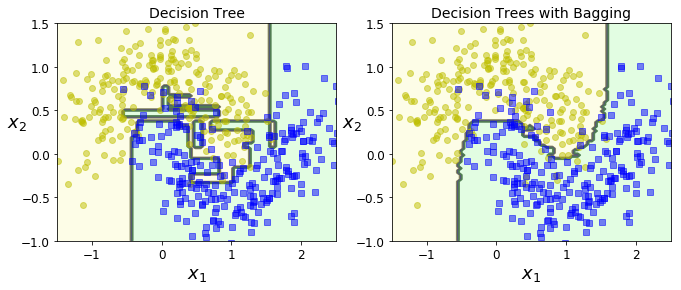

In [74]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

**Exercício**: Faça a representação gráfica dos limites de decisão de uma `Decision Tree`, do método de `Bagging` e do método de **`Pasting`** com 500 `Decision Trees` treinadas em amostras aleatórias de 100 instâncias cada, usando a mesma amostra do `moon's dataset`.

### Random Patches e Random Subspaces

O Classificador `Bagging` também permite que se faça a amostragem nas `features` também (além das instâncias).

> **Método `Random Patch`**: amostragem das instâncias e `features`;

> **Método de `Random Subspaces`**: amostragem somente nas `features`.


## Random Forests

Podemos usar o método `RandomForestClassifier` do `scikit-learn` para uso das Random Forests.

O algoritmo `RandomForestClassifier` introduz uma aleatoriedade ainda maior ao ***crescer árvores***: ao invés de escolher a melhor `feature` para o limite de decisão das `Decision Trees` da "floresta", ele escolhe a melhor `feature` de um subconjunto de `features`, escolhido aleatoriamente. 

In [76]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_rf))

0.912


Podemos escrever um método de `Bagging` para produzir um `RandomForestCalssifier`:

In [79]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

y_pred_bc = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_bc))

0.92


### Extra Trees

É possível introduzir ainda mais aleatoriedade ao método de `Random Forests`, estabelecendo os `thresholds` das `features` de forma aleatória (ao invés de procurar pelo melhor `threshold`) ==> **Extremely Randomized Trees ensemble**

`ExtraTreesClassifier` e `ExtraTreesRegressor` estão disponíveis no `scikit-learn`.

$\boxed{\text{Em geral é difícil dizer a priori qual o melhor método a se usar. O ideal é testar ambos e e comparar suas performances.} }$

### Boosting

Boosting é uma técnica geral que se refere a qualquer método de ensemble em que a combinação de estimadores/classificadores fracos individualmente, resulta em um método forte. 

Boosting: treinar estimadores **sequencialmente**, cada um tentando corrigir o seu antecessor.

### AdaBoosting

Um forma do novo estimador corrigir o antecessor é olhando para os casos de "underfitting". O resultado são novos estimadores que focam mais e mais nos casos difíceis.

Por exemplo:

1. Temos uma `Decision Tree` que classificou erroneamente algumas instâncias de treinamento;
2. O peso relativo das instâncias mal classificadas é aumentado e passado para o estimador sucessor;
3. O segundo classificador é treinado com esses pesos, faz predições e atualiza os pesos, que são passados para o quarto classificador e assim por diante.

![adaboosting](http://dfnae.fis.uerj.br/twiki/pub/DFNAE/ML4PPGF/ada_boosting.png)

A seguir, treinamos um classificador `AdaBoost` baseado em 200 `Decision Stumps` (que é uma `Decision Tree` com `max_depth=1`).

In [86]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

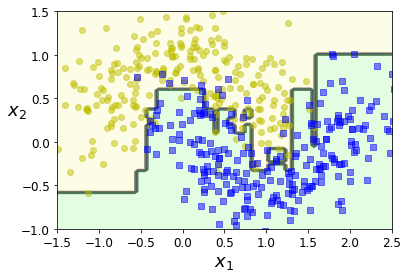

In [87]:
plot_decision_boundary(ada_clf, X, y)

Se o `AdaBoosting` estiver overfitting a amostra de treinamento, pode-se ajustar os hyperparâmetros `n_estimators`, `learning_rate`, ou tentar ***regularizar*** os estimadores base.



### Gradient Boosting

Assim como o `AdaBoosting`, o `Gradient Boosting` trabalha com estimadores sequenciais, cada um corrigindo o seu antecessor.

Mas ao invés de aplicar pesos para corrigir o estimador antecessor, o `Gradient Boosting` tenta ajustar o novo estimador aos **erros residuais** do antecessor e assim corrigir a estimativa anterior.

Vamos ver um exemplo de um estimador para uma função quadrática com ruído.

In [0]:
def quadratic_plus_noise(m = 100):
  """Quadratic training set + noise
    m: number of samples
  """
  np.random.seed(42)
  X = np.random.rand(m, 1) - 0.5
  y = 3*X[:, 0]**2 + 0.05 * np.random.randn(m)
  return X, y

X, y = quadratic_plus_noise()

O primeiro estimador é uma `Decision Tree`. Vamos fazer a predição e olhar para os resíduos:

In [96]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)



DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [97]:
#resíduos:
y2 = y - tree_reg1.predict(X)
# tree sucessora:
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)


DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [98]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Treinamos nosso método de ensemble com 3 `Decision Trees`, ajustando as duas últimas aos erros residuais.

Vamos ver como nosso `Gradient Descent` prediz o valor de y para x=0.8

In [99]:
X_new = np.array([[0.8]])
# o gradient descent é a soma dos resultados das 3 Decision Trees
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

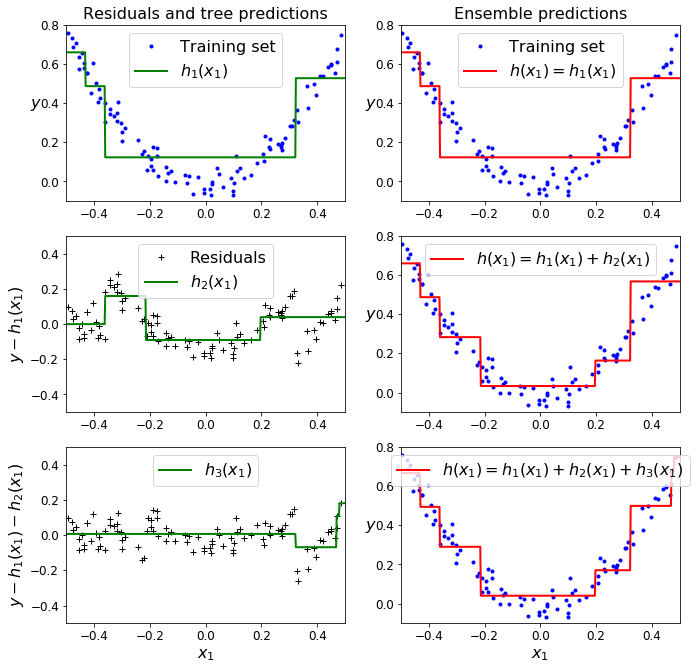

In [101]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

O `scikit-learn` tem uma classe que implementa o `GradientBoostingRegressor Tree` (GBRT). 

In [102]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

O hyperparâmetro `learning_rate`, controla a contribuição de cada `Tree` do GBRT. 

Quanto menor a `learning_rate`, maior o número de `Trees` (`n_estimators`) necessários. Mas em geral, as predições são melhores ==> técnica de ***shrinkage*** (encolhimento).

Vejamos dois exemplos de shrinkage, um com **underfitting** e outro com **overfitting**:

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)



GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [112]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

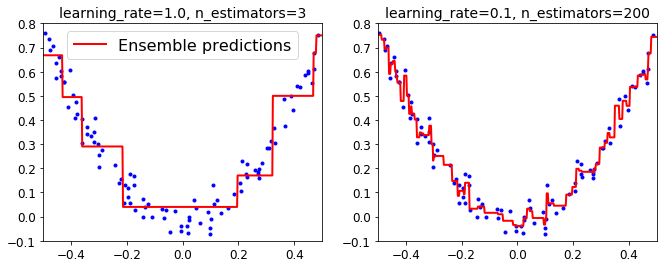

In [113]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

#save_fig("gbrt_learning_rate_plot")
plt.show()

### Gradient Boosting com `early stopping` (parada precoce)
Para encontrar o número ideal de `Trees` podemos usar a técnica de *early stopping*:
1. calcular o erro de validação a cada estágio do treinamento (com uma, duas, três, ... `Trees`)
2. encontrar o número ideal de `Trees`;
3. Treinar outro ensemble GBRT usando o número ideal de `Trees`. 

In [114]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

#calculo do erro para cada estágio da validação 
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

# o número de Trees será igual ao estágio em que o erro é o menor
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [120]:
min_error = np.min(errors)
print(min_error)

0.002712853325235463


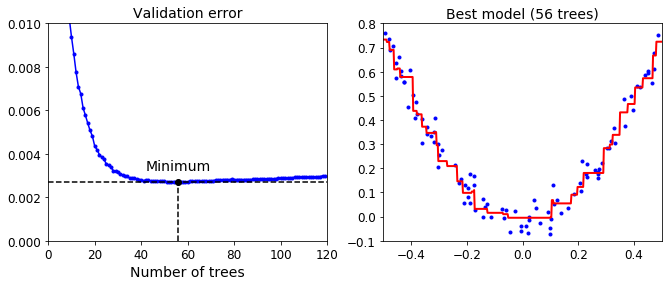

In [116]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

#save_fig("early_stopping_gbrt_plot")
plt.show()


“Também é possível implementar a parada precoce, interrompendo o treinamento mais cedo. 

Você pode fazer isso configurando `warm_start = True`, o que faz o Scikit-Learn manter as árvores existentes quando o método fit () é chamado, permitindo treinamento incremental. O código a seguir interrompe o treinamento quando o erro de validação não melhora por cinco iterações seguidas. ”

In [0]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [118]:
print(gbrt.n_estimators)


61


In [119]:
print("Minimum validation MSE:", min_val_error)


Minimum validation MSE: 0.002712853325235463
